<a href="https://colab.research.google.com/github/antontmur/decode2d/blob/master/decode2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Импорт необходимого

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from utils import de_bruijn

# Сразу зададим размеры паттерна P
WIDTH, HEIGHT = 11, 11

# Постановка задачи

**Задача:**

1. Придумать алгоритм для определения *L* - индекса строки таблицы *B* по имеющемуся паттерну *P*.
2. Для выбранного алгоритма предложить оптимальный код *B*.





**Упрощения.**

Поскольку мы заранее знаем горизонтальный индекс *С* центрального прямоугольника наблюдаемой области *P*, то задача сводится к поиску наилучшего расположения паттерна P на вертикальной оси.

Мы знаем, что размер наблюдаемого паттерна не более квадрата 11х11, а размер кода не превышает 300х300. Пользуясь указанным выше упрощением, нам достаточно рассмотреть код размером 300 строк х 11 столбцов.

Математически, мы хотим получить график распределения вероятности f(L), максимум которого соответствует вертикальной искомой вертикальной координате L (см. рисунок).



<img src="https://github.com/antontmur/decode2d/blob/master/PatternAndCode.png?raw=true" width="500">



# Решение



## Про код B
Мы хотим закодировать местоположение паттерна P с помощью последовательности чёрных и белых пикселей. При этом, мы хотим сделать это за минимальное количество пикселей.

Предположим, что нам доступен только один столбец пикселей. Тогда кодирование сводится к поиску последовательности, содержащей максимальное количество различных подпоследовательностей определённого размера. 

В комбинаторике такая последовательность задаётся с помощью [последовательности де Брёйна](https://en.wikipedia.org/wiki/De_Bruijn_sequence).

Для последовательности де Брёйна построенной из k=2 цветов (чёрный и белый), чтобы получить более 300 различных вариантов достаточно выделять подпоследовательности длины log2(300)+1 = 9.

Т.е. мы можем составить такую последовательность де Брёйна (такой код B), при котором достаточно 9 пикселей в центральном столбце, чтобы точно определить местоположение паттерна P.

В нашем случае помимо центрального столбца кода имеются другие. Для них будем так же использовать последовательность де Брёйна, только у каждого нового столбца будем сдвигать последовательность на 11 элементов. Это позволит нам получать больше информации, если в паттерне P для центрального столбца будет получено менее 9 пикселей, но будут получены пиксели для других столбцов.

In [5]:
def generate_code_B(width=11, height=300, k=2):

    # Оценим, какой длины нужны подпоследовательности,
    # чтобы длина всей последовательности была больше length
    n = int(np.log2(height)) + 1

    # Генерируем один столбец таблицы B
    # используя функцию de_bruijn()
    signal = [int(c) for c in de_bruijn(k, n)]
    signal_column = np.array(signal)[:, np.newaxis]

    # Создаём матрицу B из столбцов де Брёйна
    B = np.zeros((height, width))
    for c in range(11):
        B[:, c] = signal_column[width*c : width*c+height, 0]

    return B

Text(0, 0.5, 'Первые 30 строк матрицы B')

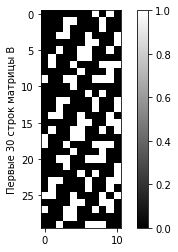

In [6]:
# Посмотрим на первые 30 строк матрицы B (кода)
B = generate_code_B()
plt.imshow(B[:30], cmap='gist_gray')
plt.colorbar()
plt.ylabel("Первые 30 строк матрицы B")

## Про алгоритм поиска

Алгоритм поиска - последовательное сравнение, насколько текущая область кода B совпадает с паттерном P. По сути, это поиск корреляции каждой отдельной части матрицы B с матрицей P.




####Нормализация на [-1; 1]

Для того, чтобы успешно рассчитывать корреляцию на светлых и тёмных пикселях, необходимо нормализовать значения B и P на интервал [-1; 1]. Таким образом, абсолютно светлый пиксель = 1, а абсолютно тёмный = -1.

Приятным побочным эффектом является то, что для пикселей, в цвете которых мы не уверены (с изначальным значением 0.5) после нормализации мы получим 0, и они не будут вносить свой вклад в суммарное значение корреляции.

Так же поступим с пикселями, которые мы не наблюдаем - зададим им значение 0.

In [7]:
def scale_to_minus1_plus1(x):

    """ Нормализуем любой массив x на [-1; 1]"""

    if np.min(x) == np.max(x):
        return np.zeros(x.shape)
    else:
        return 2.*(x - np.min(x))/np.ptp(x)-1

### Хотим больше доверять центру
В задании сказано, что мы хотим больше доверять пикселям, которые находятся в центре.
Для этого создадим дополнительно "матрицу доверия" такого же размера, как паттерн P (т.е. 11 х 11).
При этом, степень доверия будет равна единице в центре паттерна, и далее квадратично убывать, достигая значения 0.5 в крайних точках (углах) паттерна.

Text(0.5, 0, 'Матрица доверия')

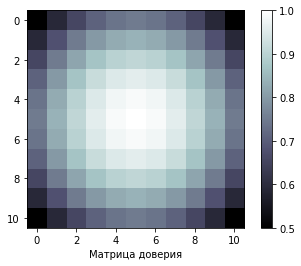

In [8]:
def trust_f(m, n):
  a = - 1/100
  m_center, n_center = 5, 5
  distance_to_center_squared = (m-m_center)**2 + (n-n_center) ** 2

  res = a * distance_to_center_squared + 1
  return res

trust_matrix = np.fromfunction(trust_f, (11, 11), dtype=float)
plt.imshow(trust_matrix, cmap='bone')
plt.colorbar()
plt.xlabel("Матрица доверия")

### Сам алгоритм

Внутри алгоритма выполняется свёртка для матрицы B на матрицу P. Будем считать, измерение каждого отдельно взятого пикселя не зависит от измерений остальных пикселей. Тогда, получаемая свёртка является количественной мерой вероятности 

In [9]:
def algorithm1(B, P, trust_center_more = False, trust_matrix=None):

    # Если мы хотим больше доверять пикселям в центре паттерна
    if trust_center_more and trust_matrix is not None:
      P = P * trust_matrix

    # Перемножим сразу всю матрицу B на паттерн P
    # Так будет быстрее - сразу матрично посчитаем свёртки всех строк
    BP = B @ P.T

    # Для каждого индекса i рассчитываем сумму i-ой диагонали матрицы BP
    # Это и есть окончательные свёртки для каждого индекса i
    f_distribution = np.array([np.trace(BP[i:i+WIDTH, :]) for i in range(BP.shape[0]-WIDTH)])

    # Разделим на количество элементов участвовавших в расчёте
    # т.е. ненулевых элементов P
    f_distribution = np.divide(f_distribution, np.count_nonzero(P))

    # Нормализуем на [0; 1] из [-1; 1], 
    # чтобы функция f не имела отрицательных значений
    f_distribution = 0.5 + f_distribution / 2

    # Найдём максимальное значение
    max_index = np.argmax(f_distribution)

    # Найдём индекс центрального элемента паттерна
    center_index = max_index + (HEIGHT-1)/2

    return int(center_index), f_distribution

# Эксперименты

In [10]:
# выберем отрезок B между строками 100 и 110 в качестве тестового примера P
test_P = B[100:111, :]

# Это значит, что искомый центр паттерна находится на строке 105

In [11]:
def add_noise(P, noise_level=0.1):

    """Функция, которая добавляет к матрице P шум амплитуды noise_level"""
    
    noise = noise_level * np.random.random_sample(P.shape)
    noise = 2 * noise - 1
    Pnoised = P+noise

    return Pnoised

# добавим шум
Pnoised = add_noise(test_P)

In [12]:
# отнормируем
P = scale_to_minus1_plus1(Pnoised)

# зачистим некоторые пиксели 
# как-будто информацию от них мы не получили
P[:3, :4] = np.zeros((3, 4))
P[8:11, 8:11] = np.zeros((3,3))
P[6:8, 10] = np.zeros((2,))
P[0, 10] = 0
P[6:10, 0] = np.zeros((4,))
P[7:10, 4] = np.zeros((3,))

Text(0.5, 0, 'После прореживания')

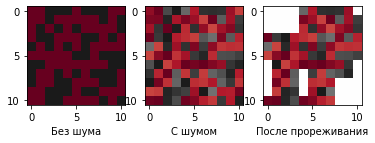

In [13]:
# Посмотрим на получаемый паттерн P
# красный = светлый пиксель (1), чёрный = тёмный пиксель (-1), белый - нет информации
plt.subplot(131)
plt.imshow(test_P, cmap='RdGy')
plt.xlabel('Без шума')
plt.subplot(132)
plt.imshow(Pnoised, cmap='RdGy')
plt.xlabel('С шумом')
plt.subplot(133)
plt.imshow(P, cmap='RdGy')
plt.xlabel('После прореживания')

In [14]:
# Запускаем алгоритм и подаём ему на вход
# сгенерированный код B и последний паттерн P (с шумом и после прореживания)
c_index_et, f_equal_trust = algorithm1(B, P)
c_index_dt, f_different_trust = algorithm1(B, P, trust_center_more=True, trust_matrix=trust_matrix)

print("Результат для случая с одинаковым доверием ко всем пикслеям: L = ", c_index_et)
print("Результат для случая с доверием ближе к центру паттерна: L = ", c_index_et)
print("Ground truth: L = 105")


Результат для случая с одинаковым доверием ко всем пикслеям: L =  105
Результат для случая с доверием ближе к центру паттерна: L =  105
Ground truth: L = 105


Text(0, 0.5, 'Функция f (одинаковое доверие)')

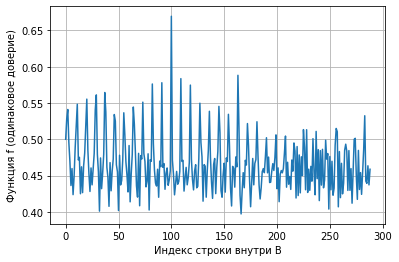

In [15]:
plt.plot(f_equal_trust)
plt.grid(True)
plt.xlabel('Индекс строки внутри B')
plt.ylabel('Функция f (одинаковое доверие)')

Text(0, 0.5, 'Функция f (доверие к центру больше)')

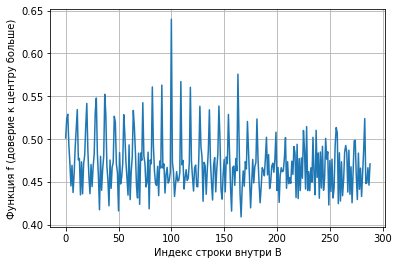

In [16]:
plt.plot(f_different_trust)
plt.grid(True)
plt.xlabel('Индекс строки внутри B')
plt.ylabel('Функция f (доверие к центру больше)')

Видим очевидный пик на уровне 100. Это означает, что верхняя граница паттерна находится на строке 100, а значит центр находится на строке 105. Это правильный ответ.

# Результаты

1. Построен алгоритм, выполняющий поиск местоположения паттерна P на вертикальной оси кода B.
2. Предложен оптимальный способ построения кода B для задания местоположения. В данных параметрах задачи местоположения паттерна моет быть задано минимум с помощью 9-ти пикселей, идущих в одном вертикальном ряду.
3. Проведён эксперимент, проверяющий предложенный алгоритм для случая непрерывных значений P, с добавлением шума и с удалением части значений P.